In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs / yobs.std(axis=0)

slab_df = 4
slab_scale = 2

## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}

model_sunode = pm.Model()

d = 12

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.01)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    lt = (pm.math.sqrt(c2)*l) / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l))
    
    z  = pm.Normal('z', mu=0, sigma=1, shape=d)
    pn = pm.Deterministic('pn', z*tau*lt)
    #pn = pm.Normal('pn', mu=0, sigma=tau*l, shape=10)
    
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:

    #trace = pm.sample(1000, tune=500, cores=2, random_seed=0, target_accept=0.99)

    real_rh_12param = pm.backends.load_trace('real_rh_12param' + '.trace',model_sunode)




In [2]:
pm.summary(real_rh_12param )

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[0],0.542,0.911,-1.158,2.158,0.111,0.079,67.0,67.0,63.0,269.0,1.04
z[1],-0.135,0.889,-1.930,1.424,0.107,0.076,69.0,69.0,77.0,57.0,1.06
z[2],0.271,0.985,-1.266,2.701,0.123,0.105,64.0,44.0,70.0,35.0,1.06
z[3],-1.129,0.708,-2.627,-0.156,0.092,0.065,60.0,60.0,80.0,88.0,1.04
z[4],-0.894,0.695,-2.410,0.198,0.067,0.048,107.0,107.0,106.0,85.0,1.02
z[5],0.926,0.702,-0.088,2.309,0.091,0.064,60.0,60.0,60.0,30.0,1.04
z[6],0.680,0.799,-0.848,2.270,0.094,0.066,73.0,73.0,77.0,89.0,1.04
z[7],0.291,0.796,-1.290,1.690,0.103,0.073,60.0,60.0,66.0,51.0,1.02
z[8],-0.416,0.775,-1.811,0.946,0.091,0.065,72.0,72.0,72.0,89.0,1.02
z[9],-0.429,0.858,-2.087,1.294,0.181,0.130,22.0,22.0,21.0,147.0,1.09


/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/traceplot.py:218: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (42), generating only 40 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d0b8825d0>,
      dtype=object)

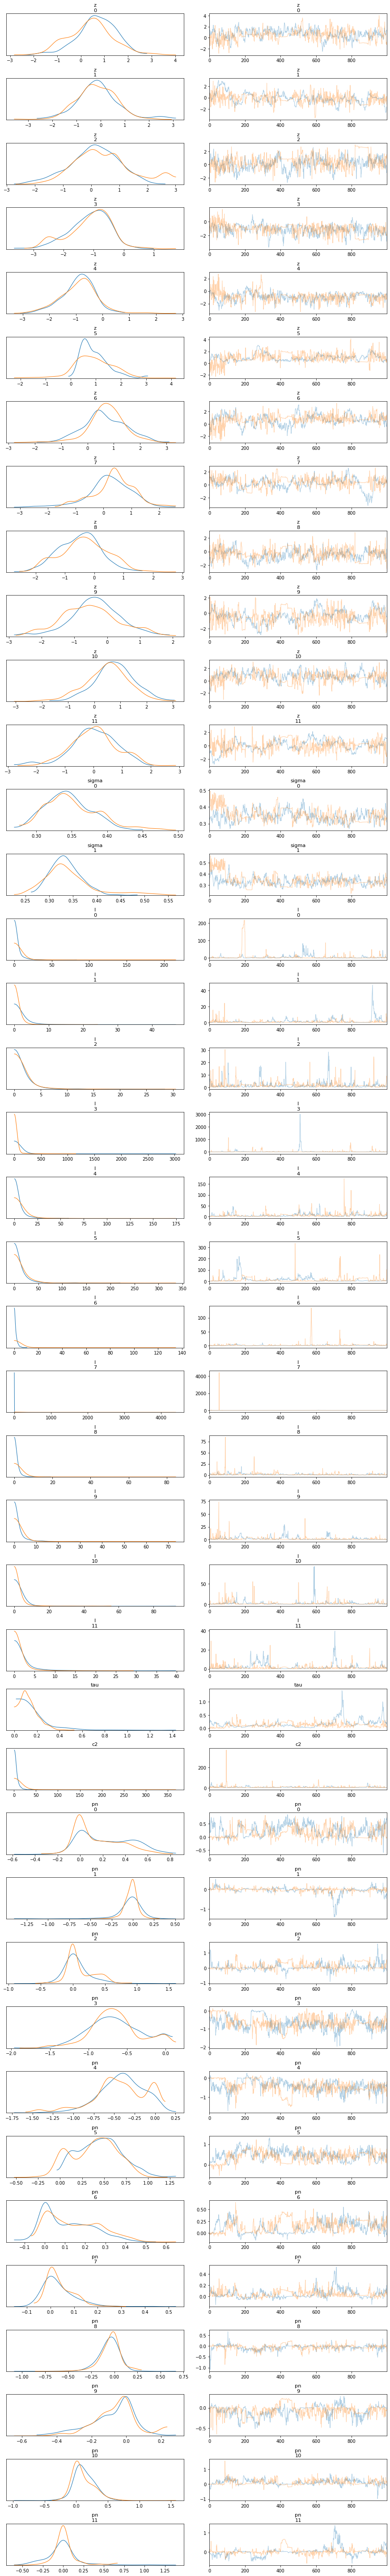

In [3]:
pm.plot_trace(real_rh_12param)

<bound method Axes.plot of <matplotlib.axes._subplots.AxesSubplot object at 0x7f3d040e3c10>>

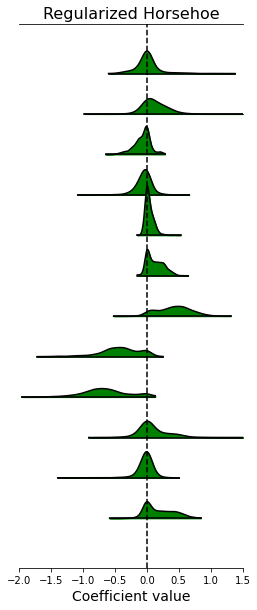

In [7]:
plt.figure(figsize=(4,10))
ax = plt.subplot(1,1,1)
ax.plot([0, 0], [-0.05, 0.5], 'k--')
pm.forestplot((real_rh_12param['pn']).T, credible_interval=0.95, kind='ridgeplot', colors='green', ridgeplot_overlap=0.05, ax=ax)
#ax.set_title('')
#ax.set_xlabel('Coefficient value')
#ax.set_ylabel('Coefficient')
ax.set_xlim(-2, 1.5)
ax.set_ylim(-0.05, 0.5)
#ax.set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85)
#ax.set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'], fontsize=16)

ax.set_xlabel('Coefficient value', fontsize=14)
plt.title('Regularized Horsehoe', fontsize=16)
plt.yticks([])    
ax.plot